In [79]:
from keras.models import Model, Sequential
from keras.layers import Dense, Lambda, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.utils.data_utils import get_file
from keras.optimizers import rmsprop, Adam
from keras.preprocessing import image


import utils; reload(utils)
from utils import plots

import os, json, subprocess
from shutil import move
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import yaml
creds = yaml.load(open('/home/ubuntu/credentials.yaml'))
kg_uname = creds['kaggle_user']
kg_pass = creds['kaggle_pass']

## Predict Type of Fish Based on Image
- Goal: Submit predictions about the class of an image based on the type of fish in an image

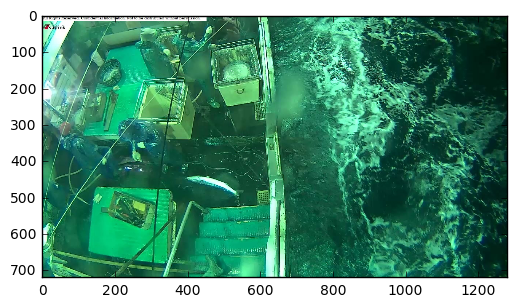

In [31]:
impath = '../../data/nature_conservancy/test_stg1/unknown/'
example_test_imgs = [impath + f for f in os.listdir(impath)]

plt.imshow(Image.open(example_test_imgs[10]))


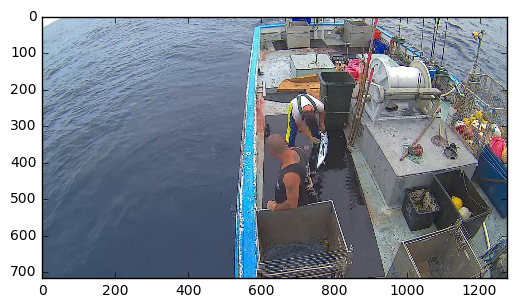

In [34]:
plt.imshow(Image.open(example_test_imgs[221]))

### Setup The Training Data
- Example of the desired directory structure at the end of this move:
```
data
    redux/
        train/
            ALB/
                img_437.jpg
                img_9924.jpg
                ...
            BET/
                img_1029.jpg
                img_4374.jpg
                ...
            ...
        valid/
            ALB/
                img_261.jpg
                img_91.jpg
                ...
            BET/
                img_1026.jpg
                img_5244.jpg
                ...
            SHARK/
            YFT/
            ...
        test/
            unknown/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

In [ ]:
#Make a Validation Set with 10% of the images from each class
path = '../../data/nature_conservancy/'
classes = ['DOL', 'YFT', 'BET', 'LAG', 'OTHER', 'NoF', 'ALB', 'SHARK']
for cls in classes:
    trainpath = path + 'train/{}/'.format(cls)
    valpath = path + 'valid/{}/'.format(cls)
    os.mkdir(valpath)
    imgs = os.listdir(trainpath)
    for img in imgs:
        nbr = int(img.split('img_')[1].split('.jpg')[0])
        if nbr % 100 < 10:
            move(trainpath + img , valpath + img)
        

### Build the model 


In [123]:
# img_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def preprocess(x):
    # x = x - img_mean
    return x/255 # reverse axis rgb->bgr
    
def create_model():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,32,32)) ) #3 colors, 32x32 pixels
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))

    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
    model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
    model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))

    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')

    return model

model = create_model()

### Training, Saving Weights Each Time

In [125]:
gen = image.ImageDataGenerator()
path = '../../data/nature_conservancy/'
tr_data = gen.flow_from_directory(path + 'train', 
                                  batch_size=8, shuffle=True, target_size=(32,32))

val_data = gen.flow_from_directory(path + 'valid', batch_size=8, 
                                   shuffle=True, target_size=(32,32))


for i in xrange(6):
    model.fit_generator(tr_data, samples_per_epoch=tr_data.nb_sample, nb_epoch=1,
                        validation_data=val_data, nb_val_samples=val_data.nb_sample)
    model.save_weights(path + 'weights/cnn_20170131_epoch_{}.h5'.format(i))

### Predictions

In [56]:
model.load_weights('../../data/nature_conservancy/weights/vgg_churn_epoch_5.h5')
test_data = gen.flow_from_directory(path + 'test_stg1/', batch_size=8, 
                                   shuffle=False, target_size=(224,224))


Found 1000 images belonging to 1 classes.


In [97]:
def create_submission(predictions, test_id, info, save=False):
    result1 = pd.DataFrame(predictions, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
    result1.loc[:, 'image'] = pd.Series(test_id, index=result1.index)
    now = dt.datetime.now()
    subpath = '../../data/nature_conservancy/submissions/'
    sub_file = subpath + 'sub_' + info  + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    order = ['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    result1 = result1[order]
    result1.to_csv(sub_file, index=False)
    return result1, sub_file

In [107]:
img_ids = [img.split('/')[1] for img in test_data.filenames]
# preds = model.predict_generator(test_data, test_data.nb_sample)
results, fname = create_submission(preds, img_ids, "vgg", save=True)
print fname

../../data/nature_conservancy/submissions/sub_vgg_2017-01-31-16-37.csv


In [108]:
results.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,img_06893.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,img_02082.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,img_06261.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,img_03628.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
comp = 'the-nature-conservancy-fisheries-monitoring'
cmd = "kg submit {} -c {} -u {} -p {} -m 'vgg model'".format(fname, comp, kg_uname, kg_pass)
subprocess.check_output(cmd, shell=True)